In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
import math
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, SelectKBest, SelectFwe
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
from xgboost import plot_importance

C:\Users\rickr\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# ingore warning
warnings.filterwarnings("ignore")

# 1. Data Preprocessing

In [3]:
def CheckWeekend(year, month, day):
    convertDate = datetime.date(year, month, day)
    convertDateResult = convertDate.weekday()
    if convertDateResult <= 4:
        return False
    return True

# import dataset
df = pd.read_excel("Data_Train.xlsx", engine='openpyxl')

# drop null value
df.dropna(inplace=True)

# drop duplicates
df.drop_duplicates(keep='first', inplace=True)

# convert Dep_Time and Arrival_Time into hour and minute
# Dep_Time
df["Dep_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour
df["Dep_minute"] = pd.to_datetime(df["Dep_Time"]).dt.minute
df = df.drop(columns="Dep_Time")

# Arrival_Time
df["Arr_hour"] = pd.to_datetime(df["Arrival_Time"]).dt.hour
df["Arr_minute"] = pd.to_datetime(df["Arrival_Time"]).dt.minute
df = df.drop(columns="Arrival_Time")

# convert Date_of_Journey into timestamp
df["Date_of_Journey_Year"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.year
# ps. I don't think "year" is mandatory
df["Date_of_Journey_Month"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.month
df["Date_of_Journey_Day"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.day
df = df.drop(columns="Date_of_Journey")


# convert Duration into minute
df['Duration'] = df['Duration']\
    .str.replace("h", '*60')\
    .str.replace(' ', '+')\
    .str.replace('m', '*1')\
    .apply(eval)

# drop Additional_Info 
df.drop(['Additional_Info'], axis=1, inplace=True)

# drop Route
df.drop(['Route'], axis=1, inplace=True) 

# Encode categorical attributes
# Select categorical data
df_categorical = df[['Airline', 'Source', 'Destination']]
df.drop(['Airline', 'Source', 'Destination'], axis=1, inplace=True)


# Encode
df_categorical = pd.get_dummies(df_categorical, drop_first=True)
df['Total_Stops'] = df['Total_Stops'].map({"non-stop":0, "1 stop": 1, "2 stops": 2, "3 stops":3, "4 stops": 4})

# Concat categorical and numerical data
preprocessed = pd.concat([df, df_categorical], axis=1)
target = df['Price']

# Drop 'Price' because price is the target variable
preprocessed.drop(['Price'], axis=1, inplace=True)

## Feature Engineering - check if date is weekday or weekend
preprocessed["IsWeekend"] = preprocessed.apply(lambda x: 1 if CheckWeekend(x["Date_of_Journey_Year"], x["Date_of_Journey_Month"], x["Date_of_Journey_Day"]) else 0, axis=1)


# 2. Model Training & Performance

In [4]:
# Train_Test_Split
data_train, data_test, target_train, target_test = train_test_split(
    preprocessed, target,test_size=0.3, random_state=42)

In [5]:
data_train.head()

,Duration,Total_Stops,Dep_hour,Dep_minute,Arr_hour,Arr_minute,Date_of_Journey_Year,Date_of_Journey_Month,Date_of_Journey_Day,Airline_Air India,...,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,IsWeekend
5050,1830,3,16,45,23,15,2019,4,1,1,...,0,0,1,0,0,0,0,0,0,0
4879,480,1,13,0,21,0,2019,6,1,0,...,0,1,0,0,1,0,0,0,0,1
208,570,1,14,5,23,35,2019,5,21,0,...,0,0,1,0,0,0,0,0,0,0
8561,930,1,10,0,1,30,2019,6,9,0,...,0,1,0,0,1,0,0,0,0,1
7265,165,0,22,10,0,55,2019,3,21,0,...,0,0,1,0,0,0,0,0,0,0


In [6]:
data_test.head()

,Duration,Total_Stops,Dep_hour,Dep_minute,Arr_hour,Arr_minute,Date_of_Journey_Year,Date_of_Journey_Month,Date_of_Journey_Day,Airline_Air India,...,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,IsWeekend
2150,1455,1,8,0,8,15,2019,3,6,0,...,0,0,0,0,0,0,0,0,1,0
3784,140,0,22,20,0,40,2019,6,6,0,...,0,0,1,0,0,0,0,0,0,0
714,170,0,5,30,8,20,2019,3,18,0,...,0,0,1,0,0,0,0,0,0,0
7558,90,0,15,50,17,20,2019,3,24,0,...,0,0,0,1,0,0,1,0,0,1
7413,170,0,9,30,12,20,2019,4,27,0,...,0,0,0,0,0,1,0,0,0,1


In [7]:
# normalize 'duration'

# Copy data
data_train_normalize = data_train.copy()
data_test_normalize = data_test.copy()

# create the normaliser
scaler = preprocessing.StandardScaler()
data_train_normalize[['Duration']] = scaler.fit_transform(data_train_normalize[['Duration']])
data_test_normalize[['Duration']] = scaler.fit_transform(data_test_normalize[['Duration']])

data_train_normalize.head()

,Duration,Total_Stops,Dep_hour,Dep_minute,Arr_hour,Arr_minute,Date_of_Journey_Year,Date_of_Journey_Month,Date_of_Journey_Day,Airline_Air India,...,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,IsWeekend
5050,2.408958,3,16,45,23,15,2019,4,1,1,...,0,0,1,0,0,0,0,0,0,0
4879,-0.303560,1,13,0,21,0,2019,6,1,0,...,0,1,0,0,1,0,0,0,0,1
208,-0.122725,1,14,5,23,35,2019,5,21,0,...,0,0,1,0,0,0,0,0,0,0
8561,0.600613,1,10,0,1,30,2019,6,9,0,...,0,1,0,0,1,0,0,0,0,1
7265,-0.936481,0,22,10,0,55,2019,3,21,0,...,0,0,1,0,0,0,0,0,0,0


In [8]:
# score function
def cal_score(model, normalize=False):
    if normalize:
        X_test = data_test_normalize
    else:
        X_test = data_test
        
    predictions = model.predict(X_test)
    
    # R-Squared
    R2_score = r2_score(target_test, predictions)
    R2_scores.append(R2_score)
    print('R-squared: ' + str(R2_score))

    # RMSE
    RMSE_score = mean_squared_error(predictions, target_test, squared=False)
    RMSE_scores.append(RMSE_score)
    print("RMSE : " + str(RMSE_score))

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
def reverse_scores():
    R2_scores.pop()
    RMSE_scores.pop()

In [11]:
R2_scores = []
RMSE_scores = []

### 0. Average Price as Prediction (Baseline)

In [12]:
# create prediction result
average_price = target_train.mean()
y_pred_average_price = np.empty(len(target_test))
y_pred_average_price.fill(average_price)
y_pred_average_price

array([9053.2321453, 9053.2321453, 9053.2321453, ..., 9053.2321453,
       9053.2321453, 9053.2321453])

In [13]:
# performance

# R-Squared
R2_score = r2_score(target_test, y_pred_average_price)
R2_scores.append(R2_score)
print('R-squared: ' + str(R2_score))

# RMSE
RMSE_score = mean_squared_error(y_pred_average_price, target_test, squared=False)
RMSE_scores.append(RMSE_score)
print("RMSE : " + str(RMSE_score))

R-squared: -0.00037395873469936447
RMSE : 4558.1088719559


### 1. Linear Regression

#### 1-1. Model Training

In [14]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(data_train, target_train)

LinearRegression()

#### 1-2. Performance

In [15]:
cal_score(linear_regression_model)

R-squared: 0.6115210423588688
RMSE : 2840.4506954550006


#### 1-3. Analysis

In [16]:
# Calculate the number of samples and predictors
n = len(target_test)
p = data_test.shape[1]

# Calculate adjusted R-squared
adjusted_r2 = 1 - (1 - R2_scores[0]) * (n - 1) / (n - p - 1)

# Print the adjusted R-squared score
print("Adjusted R-Squared (Adjusted R^2):", adjusted_r2)

Adjusted R-Squared (Adjusted R^2): -0.01003007802750533


In [17]:
# Average value of the dependent variable, if all independent variables have the value 0 or are not considered

print("Intercept:",linear_regression_model.intercept_)

Intercept: 6991.540366260865


In [18]:
# Coefficients for each feature

print(linear_regression_model.coef_)

[ 4.76469189e-02  2.83376931e+03  2.30901694e+01 -1.30917910e+00
 -6.35968780e+00  3.11882488e+00 -3.54134500e-11 -4.06915554e+02
 -7.32694139e+01  1.60431228e+03 -3.20685683e+01  2.60489394e+02
  4.45856510e+03  4.66212381e+04  3.83652042e+03  4.06498502e+03
 -2.04231800e+02 -1.81898940e-12  2.11016359e+03  2.84863462e+03
  6.17196021e+01 -1.10967736e+01 -1.23065878e+02 -8.13110340e+02
 -1.10967736e+01 -8.46726376e+02 -8.13110340e+02  6.17196021e+01
  1.73227977e+03  2.12502689e+02]


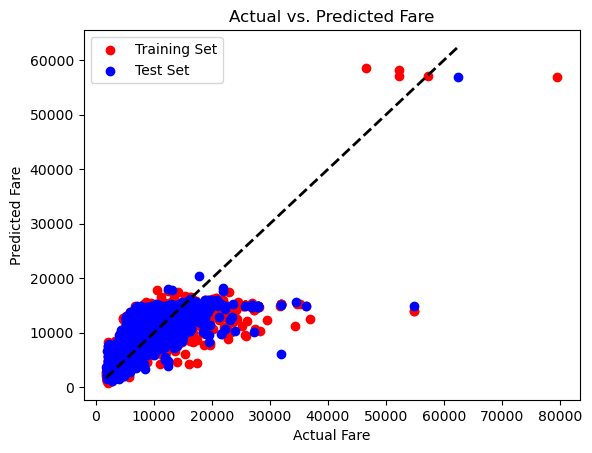

In [19]:
# Plotting the linear regression
plt.scatter(target_train, linear_regression_model.predict(data_train), color='red', label='Training Set')
plt.scatter(target_test, linear_regression_model.predict(data_test), color='blue', label='Test Set')
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2)
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('Actual vs. Predicted Fare')
plt.legend()
plt.show()

### 2. Polynomial Regression

#### 2-1. Model Training

In [20]:
# create a transformer
transformer = PolynomialFeatures(degree=2, include_bias=False)

best = SelectFwe(f_regression, alpha=0.05)
estimator = LinearRegression()

poly_regression_model = Pipeline([ ('transformer', transformer), ('feature_selection', best), ('estimator', estimator)])

# fit the regression on the training data
poly_regression_model.fit(data_train_normalize, target_train)

Pipeline(steps=[('transformer', PolynomialFeatures(include_bias=False)),
                ('feature_selection',
                 SelectFwe(score_func=<function f_regression at 0x00000156B9E04550>)),
                ('estimator', LinearRegression())])

#### 2-2. Performance

In [21]:
cal_score(poly_regression_model, normalize=True)

R-squared: 0.6850028199290117
RMSE : 2557.742608306682


#### 2-3. Analysis

In [22]:
# create a transformer
transformer = PolynomialFeatures(degree=2, include_bias=False)

# run the F-Test
f, pval = f_regression(transformer.fit_transform(data_train), target_train)

# prepare a dataframe to inspect the results
stat = pd.DataFrame({ 'feature': transformer.get_feature_names_out(data_train.columns), 'F value': f, 'p value': pval })
stat['p value'] = round(stat['p value'], 2)

# show the results
display(stat)

count = 0
for i in range(len(stat)):
    if(math.isnan(stat['F value'][i])):
        count = count+1
print(count)

,feature,F value,p value
0,Duration,2418.001683,0.00
1,Total_Stops,4080.632555,0.00
2,Dep_hour,1.997667,0.16
3,Dep_minute,4.815703,0.03
4,Arr_hour,7.350185,0.01
...,...,...,...
490,Destination_Kolkata Destination_New Delhi,0.000000,1.00
491,Destination_Kolkata IsWeekend,50.370959,0.00
492,Destination_New Delhi^2,302.040290,0.00
493,Destination_New Delhi IsWeekend,13.395025,0.00


0


In [23]:
# get the selected features
selected_features = poly_regression_model.named_steps['feature_selection'].get_support()

# print the selected variables
for i, f in enumerate(poly_regression_model.named_steps['transformer'].get_feature_names_out(data_train.columns)):
    if selected_features[i]:
        print(f)

Duration
Total_Stops
Arr_minute
Date_of_Journey_Month
Date_of_Journey_Day
Airline_Air India
Airline_GoAir
Airline_IndiGo
Airline_Jet Airways
Airline_Jet Airways Business
Airline_Multiple carriers
Airline_SpiceJet
Airline_Vistara
Source_Chennai
Source_Delhi
Source_Mumbai
Destination_Cochin
Destination_Delhi
Destination_Hyderabad
Destination_Kolkata
Destination_New Delhi
Duration^2
Duration Total_Stops
Duration Dep_hour
Duration Dep_minute
Duration Arr_hour
Duration Arr_minute
Duration Date_of_Journey_Year
Duration Date_of_Journey_Month
Duration Date_of_Journey_Day
Duration Airline_Air India
Duration Airline_GoAir
Duration Airline_IndiGo
Duration Airline_Jet Airways
Duration Airline_Jet Airways Business
Duration Airline_SpiceJet
Duration Airline_Vistara
Duration Source_Chennai
Duration Source_Delhi
Duration Source_Kolkata
Duration Source_Mumbai
Duration Destination_Cochin
Duration Destination_Delhi
Duration Destination_Hyderabad
Duration Destination_Kolkata
Duration Destination_New Delhi

### 3. Regression Tree

#### 3-1. Model Training without Tuning

In [24]:
# Initializing the Decision Tree Regression model
rg_tree_basic = DecisionTreeRegressor(random_state = 42)

# Fitting the Decision Tree Regression model to the data
rg_tree_basic.fit(data_train, target_train)

DecisionTreeRegressor(random_state=42)

#### 3-2. Model Training with hyperparameter tuning

In [25]:
# specify the parameter grid
parameter_grid = {'max_features': ['auto', 'sqrt'],
          'max_depth':[int(x) for x in np.linspace(start = 1, stop = 20, num = 20)],
          'min_samples_leaf':[int(x) for x in np.linspace(start = 1, stop = 20, num = 20)],
          'min_samples_split':[int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
         }

regression_tree_model = DecisionTreeRegressor(random_state = 42)
regression_tree_rs = RandomizedSearchCV(random_state = 42, estimator=regression_tree_model, param_distributions=parameter_grid, scoring='neg_mean_squared_error', cv=5, n_iter=10)
regression_tree_rs.fit(data_train, target_train)
print('Best parameters: ',regression_tree_rs.best_params_)
print('Best R-sqaured score: ',regression_tree_rs.best_score_)

Best parameters:  {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 15}
Best R-sqaured score:  -6511469.989729738


#### 3-3. Performance

In [26]:
print("Model without hyperparameter tuning")
print("")

#use cross-validation to estimate model performance
cross_regression_tree = cross_val_score(rg_tree_basic, data_train, target_train, cv=10, scoring='r2')
print('Average Cross-Validation R-squared score: ', cross_regression_tree.mean())


# Predicting the target values of the test set
y_pred = rg_tree_basic.predict(data_test)


#Evaluate the model on the testing set
#r_squared
r2_regression_tree = r2_score(target_test, y_pred)
print('R-Squared:', r2_regression_tree)

#RMSE
root_mean_squared_error_regression_tree = mean_squared_error(target_test, y_pred, squared=False)
print('RMSE:', root_mean_squared_error_regression_tree)

print("---------------------------------------")

print("Model with hyperparameter tuning")
print("")

cross_regression_tree = cross_val_score(regression_tree_rs, data_train, target_train, cv=10, scoring='r2')
print('Average Cross-Validation R-squared score: ', cross_regression_tree.mean())

cal_score(regression_tree_rs)

Model without hyperparameter tuning

Average Cross-Validation R-squared score:  0.6883334583334569
R-Squared: 0.6903080744088547
RMSE: 2536.112102368029
---------------------------------------
Model with hyperparameter tuning

Average Cross-Validation R-squared score:  0.7115753408131666
R-squared: 0.7308717527849882
RMSE : 2364.194195710645


#### 3-4. Analysis

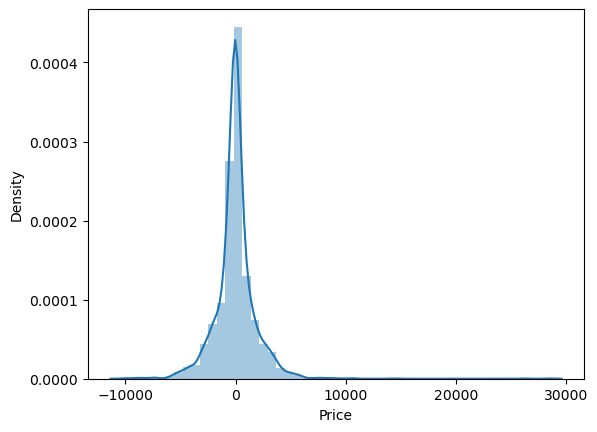

### 4. Random Forest

#### 4-1. Training without Tuning

In [27]:
rf_model_basic = RandomForestRegressor()
rf_model_basic.fit(data_train, target_train)

RandomForestRegressor()

#### 4-2. Training with hyperparameter tuning

In [28]:
# specify the parameter grid
parameter_grid = {
    'max_depth': [int(x) for x in np.linspace(10, 100, 10)],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [int(x) for x in np.linspace(50, 500, 10)]
}

In [29]:
# specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

rf_model = RandomForestRegressor()
rf_model_rs = RandomizedSearchCV(rf_model, parameter_grid, scoring='neg_mean_squared_error', cv=stratified_10_fold_cv, error_score='raise')

rf_model_rs.fit(data_train, target_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(rf_model_rs.cv_results_)
display(results)

# print the best parameter setting
print("Best score is {} with params {}".format(rf_model_rs.best_score_, rf_model_rs.best_params_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.345550,0.022090,0.068873,0.010887,350,5,2,sqrt,100,"{'n_estimators': 350, 'min_samples_split': 5, ...",...,-7.209397e+06,-4.558531e+06,-3.200058e+06,-5.024154e+06,-6.261589e+06,-3.498276e+06,-3.729591e+06,-4.533795e+06,1.279977e+06,8
1,2.692846,0.052756,0.082931,0.003300,500,2,4,sqrt,100,"{'n_estimators': 500, 'min_samples_split': 2, ...",...,-8.677811e+06,-4.882599e+06,-3.390647e+06,-7.136060e+06,-7.970409e+06,-3.872567e+06,-4.675719e+06,-5.340203e+06,1.830301e+06,10
2,8.792106,0.087729,0.090363,0.009904,500,5,4,auto,30,"{'n_estimators': 500, 'min_samples_split': 5, ...",...,-7.450644e+06,-3.978904e+06,-3.010861e+06,-6.251620e+06,-7.210634e+06,-3.345880e+06,-4.068222e+06,-4.622437e+06,1.646269e+06,9
3,3.165997,0.048737,0.029769,0.001275,150,5,2,auto,100,"{'n_estimators': 150, 'min_samples_split': 5, ...",...,-7.684854e+06,-4.134693e+06,-3.380566e+06,-4.843166e+06,-5.661793e+06,-3.147151e+06,-3.171324e+06,-4.272877e+06,1.417191e+06,5
4,2.206421,0.101176,0.024655,0.001451,150,2,2,auto,10,"{'n_estimators': 150, 'min_samples_split': 2, ...",...,-7.725726e+06,-4.281729e+06,-3.258173e+06,-4.832929e+06,-5.828260e+06,-3.439433e+06,-3.157476e+06,-4.374482e+06,1.415993e+06,6
5,1.997071,0.049941,0.020180,0.001218,100,10,1,auto,60,"{'n_estimators': 100, 'min_samples_split': 10,...",...,-6.178294e+06,-3.718811e+06,-2.980735e+06,-3.845882e+06,-5.431870e+06,-3.174918e+06,-3.358438e+06,-3.933099e+06,1.057905e+06,2
6,6.950538,0.110132,0.064412,0.001995,350,10,1,auto,50,"{'n_estimators': 350, 'min_samples_split': 10,...",...,-6.247501e+06,-3.745732e+06,-2.953755e+06,-3.610877e+06,-5.228120e+06,-3.115179e+06,-3.298096e+06,-3.875965e+06,1.064242e+06,1
7,8.024205,0.057876,0.069026,0.003906,300,2,1,auto,100,"{'n_estimators': 300, 'min_samples_split': 2, ...",...,-6.175704e+06,-4.155542e+06,-3.637433e+06,-4.085803e+06,-5.979719e+06,-3.341668e+06,-3.569879e+06,-4.221078e+06,9.885796e+05,4
8,5.272627,0.570106,0.050803,0.007261,250,10,2,auto,50,"{'n_estimators': 250, 'min_samples_split': 10,...",...,-7.639160e+06,-3.985493e+06,-2.901865e+06,-4.931251e+06,-5.656505e+06,-3.089369e+06,-3.197423e+06,-4.203651e+06,1.464335e+06,3
9,4.706209,0.337490,0.120249,0.012521,500,2,2,sqrt,80,"{'n_estimators': 500, 'min_samples_split': 2, ...",...,-7.211188e+06,-4.566137e+06,-3.208416e+06,-5.051188e+06,-6.133893e+06,-3.429849e+06,-3.719369e+06,-4.522461e+06,1.270827e+06,7


Best score is -3875964.5539377937 with params {'n_estimators': 350, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50}


#### 4-3. Performance

In [30]:
print("Model without hyperparameter tuning")
print("")

# Predicting the target values of the test set
y_pred = rf_model_basic.predict(data_test)


#Evaluate the model on the testing set
#r_squared
r2_rf = r2_score(target_test, y_pred)
print('R-Squared:', r2_rf)

#RMSE
root_mean_squared_error_rf = mean_squared_error(target_test, y_pred, squared=False)
print('RMSE:', root_mean_squared_error_rf)

print("---------------------------------------")

print("Model with hyperparameter tuning")
print("")

cal_score(rf_model_rs)

Model without hyperparameter tuning

R-Squared: 0.8184986409726845
RMSE: 1941.5270512309155
---------------------------------------
Model with hyperparameter tuning

R-squared: 0.8323390697507159
RMSE : 1866.0335209816387


#### 4-4. Analysis

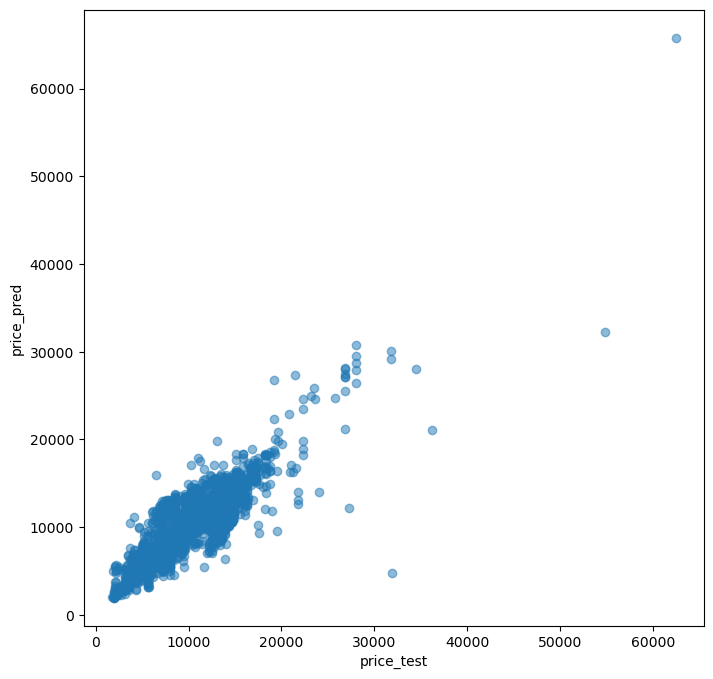

In [31]:
# Before Tuning
prediction = rf_model_basic.predict(data_test)

plt.figure(figsize=(8, 8))
plt.scatter(target_test, prediction, alpha=0.5)
plt.xlabel("price_test")
plt.ylabel("price_pred")
plt.show()

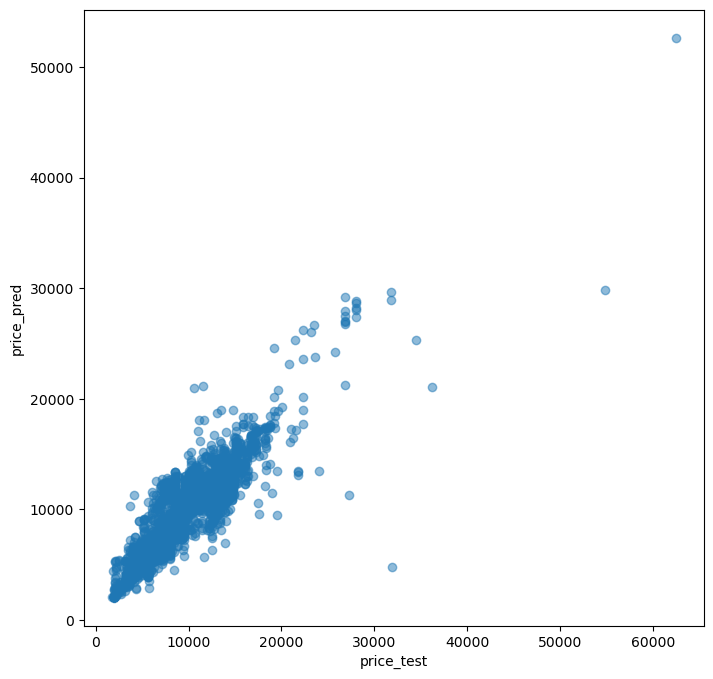

In [32]:
# After Tuning
prediction = rf_model_rs.best_estimator_.predict(data_test)

plt.figure(figsize=(8, 8))
plt.scatter(target_test, prediction, alpha=0.5)
plt.xlabel("price_test")
plt.ylabel("price_pred")
plt.show()

In [33]:
# impurity-based importances
importances = rf_model_rs.best_estimator_.feature_importances_
for i, f in zip(list(data_train.columns), importances):
    print(f"{i}: {round(f*100, 2)}")

Duration: 47.26
Total_Stops: 3.02
Dep_hour: 2.07
Dep_minute: 2.01
Arr_hour: 3.17
Arr_minute: 1.77
Date_of_Journey_Year: 0.0
Date_of_Journey_Month: 5.7
Date_of_Journey_Day: 11.89
Airline_Air India: 0.41
Airline_GoAir: 0.18
Airline_IndiGo: 0.69
Airline_Jet Airways: 6.47
Airline_Jet Airways Business: 7.94
Airline_Multiple carriers: 2.11
Airline_Multiple carriers Premium economy: 0.09
Airline_SpiceJet: 0.24
Airline_Trujet: 0.0
Airline_Vistara: 0.27
Airline_Vistara Premium economy: 0.0
Source_Chennai: 0.06
Source_Delhi: 0.25
Source_Kolkata: 0.37
Source_Mumbai: 0.42
Destination_Cochin: 0.24
Destination_Delhi: 0.04
Destination_Hyderabad: 0.45
Destination_Kolkata: 0.07
Destination_New Delhi: 2.22
IsWeekend: 0.58


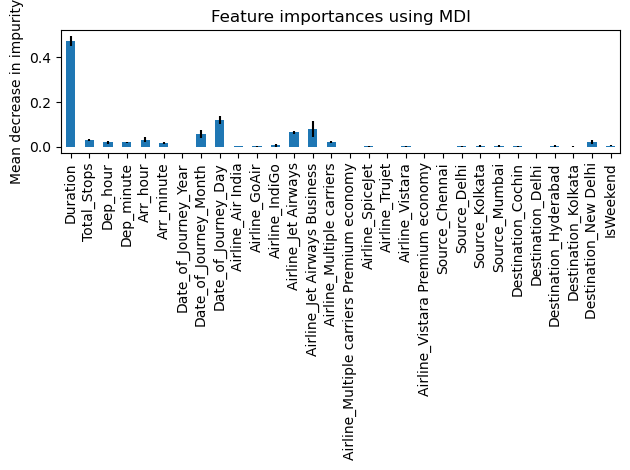

In [34]:
forest_importances = pd.Series(importances, index=list(data_train.columns))

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf_model_rs.best_estimator_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### 5. XGBoost

#### 5-1. Training without Tuning

In [48]:
xgboost_model_basic = XGBRegressor()
xgboost_model_basic.fit(data_train,target_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

#### 5-2. Training with hyperparameter tuning

In [36]:
# specify the parameter grid
n_estimators_range = list(np.arange(100,501,100))
leaning_rate_range = [0.01, 0.05, 0.1]
max_depth_range = list(np.arange(5,15,1))
reg_lambda_range = [0.001, 0.1, 1.0, 10.0, 100.0]

parameter_grid = {"n_estimators": n_estimators_range, 
                  "learning_rate": leaning_rate_range,
                  "max_depth": max_depth_range,
                  "reg_lambda": reg_lambda_range}

# Hyperparameter Optimization
xgboost_model = XGBRegressor()
xgboost_rs = RandomizedSearchCV(xgboost_model, parameter_grid, scoring="neg_mean_squared_error", cv=5)
xgboost_rs.fit(data_train,target_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          predictor=None, random_state=None,
                                          reg_alpha=None, reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [5, 6, 7, 8, 9, 10, 11, 12,
                                                      13, 14],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_lambda': [0.001, 0.1, 1.0, 10.0,
                                                       100.0]},
                   scoring='neg_mean_squared_error')

#### 5-3. Performance

In [47]:
print("Model without hyperparameter tuning")
print("")

# Predicting the target values of the test set
y_pred = xgboost_model_basic.predict(data_test)


#Evaluate the model on the testing set

#r_squared
r2_rf = r2_score(target_test, y_pred)
print('R-Squared:', r2_rf)

mae_score = mean_absolute_percentage_error(target_test, y_pred)
print('MAE(%):', mae_score)

#RMSE
root_mean_squared_error_rf = mean_squared_error(target_test, y_pred, squared=False)
print('RMSE:', root_mean_squared_error_rf)

print("---------------------------------------")

print("Model with hyperparameter tuning")
print("")

y_pred = xgboost_rs.predict(data_test)

#r_squared
r2_rf = r2_score(target_test, y_pred)
print('R-Squared:', r2_rf)

mae_score = mean_absolute_percentage_error(target_test, y_pred)
print('MAE(%):', mae_score)

#RMSE
root_mean_squared_error_rf = mean_squared_error(target_test, y_pred, squared=False)
print('RMSE:', root_mean_squared_error_rf)

# cal_score(xgboost_rs)

Model without hyperparameter tuning

R-Squared: 0.8165342243632028
MAE(%): 13.577111218407598
RMSE: 1952.0054952798544
---------------------------------------
Model with hyperparameter tuning

R-Squared: 0.8254832207231576
MAE(%): 13.060887000269556
RMSE: 1903.8034085085703


#### 5-4. Analysis

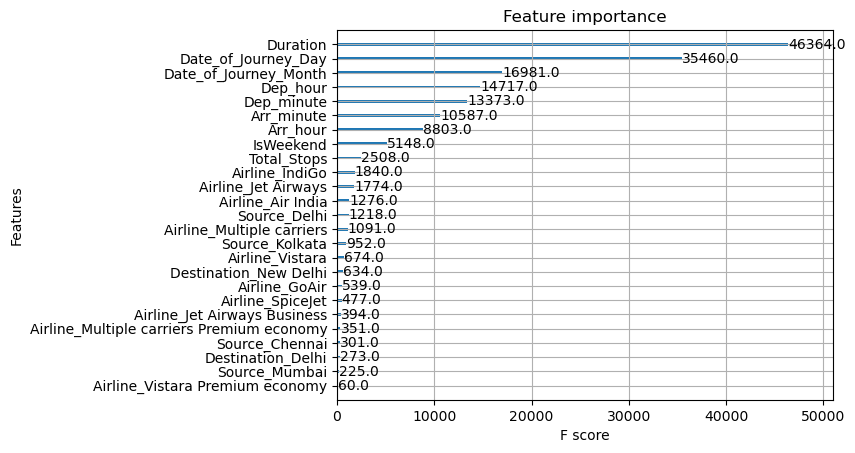

In [38]:
# impurity-based importances
plot_importance(xgboost_rs.best_estimator_)
plt.show()

# 3. Comparison

In [39]:
# print out all of the results
grid_dict = {0: 'Linear Regression', 1: 'Polynomial Regression', 2: 'Regression Tree', 3: 'Random Forest', 4: 'XGBoost'}

print('Average Price(Baseline)')
print('R-squared: {}'.format(R2_scores[0]))
print('RMSE: {}'.format(RMSE_scores[0]))
print('')

for i in range(len(grid_dict)):
    print('Model {}: {}'.format(i+1, grid_dict[i]))
    print('R-squared: {}'.format(R2_scores[i+1]))
    print('RMSE: {}'.format(RMSE_scores[i+1]))
    print('')

Average Price(Baseline)
R-squared: -0.00037395873469936447
RMSE: 4558.1088719559

Model 1: Linear Regression
R-squared: 0.6115210423588688
RMSE: 2840.4506954550006

Model 2: Polynomial Regression
R-squared: 0.6850028199290117
RMSE: 2557.742608306682

Model 3: Regression Tree
R-squared: 0.7308717527849882
RMSE: 2364.194195710645

Model 4: Random Forest
R-squared: 0.8323390697507159
RMSE: 1866.0335209816387

Model 5: XGBoost
R-squared: 0.8254832207231576
RMSE: 1903.8034085085703



# 3.  德國